## 2. ホテリングの$T^2$法による異常検知
### 2.1 多変量正規分布の最尤推定
$M$次元ベクトル$\boldsymbol{x}$がN個観測されているとする。
$$
D=\{\boldsymbol{x}^{(1)},\boldsymbol{x}^{(2)},\cdots,\boldsymbol{x}^{(N)}\}
$$

ホテリングの$t^2$法では、このデータが異常標本を含まないか、含んでいたとしてもごく少数であるという前提のもと、  
各標本が独立に次の確率密度関数に従うと仮定する。
$$
N(\boldsymbol{x}|\boldsymbol{\mu},\boldsymbol{\Sigma})=\frac{|\Sigma|^{-1/2}}{(2\pi)^{M/2}}\exp{\biggl\{-\frac{1}{2}(\boldsymbol{x}-\boldsymbol{\mu})^T\Sigma^{-1}(\boldsymbol{x}-\boldsymbol{\mu}) \biggr\}}
$$

この確率密度関数を**正規分布(ガウス分布)**と呼ぶ。  
$\mu$は平均、$\Sigma$は共分散行列、$|・|$は行列式を表している。  
また、$\Sigma^{-1}$をしばしば$\Lambda$で表し、これを**精度行列**と呼ぶ。  
  
パラメータをデータ$D$から決める方法として、**最尤推定**と呼ばれるものがある。  
$D$の対数尤度$L(\boldsymbol{\mu},\Sigma|D)$は次のようになる。
$$
L(\boldsymbol{\mu},\Sigma|D)=\ln{\prod_{n=1}^N N(\boldsymbol{x}^{(n)}|\boldsymbol{\mu},\Sigma)}=\sum_{n=1}^N\ln{ N(\boldsymbol{x}^{(n)}|\boldsymbol{\mu},\Sigma)}
$$

これを最大化するようにパラメータを決める。  
多変量正規分布の定義を代入する。
$$
L(\boldsymbol{\mu},\Sigma|D)=-\frac{MN}{2}\ln{(2\pi)}-\frac{N}{2}\ln{|\Sigma|}-\frac{1}{2}\sum_{n=1}^N(\boldsymbol{x}^{(n)}-\boldsymbol{\mu})^T\Sigma^{-1}(\boldsymbol{x}^{(n)}-\boldsymbol{\mu})
$$

$L(\boldsymbol{\mu},\Sigma|D)$を$\boldsymbol{\mu}$で微分して0と等値とする。  
$$
\frac{\partial L(\boldsymbol{\mu},\Sigma|D)}{\partial \boldsymbol{\mu}}=\sum_{n=1}^N\Sigma^{-1}(\boldsymbol{x}^{(n)}-\boldsymbol{\mu})
$$

最尤解$\hat{\boldsymbol{\mu}}$は、
$$
\hat{\boldsymbol{\mu}}=\frac{1}{N}\sum_{i=1}^N\boldsymbol{x}^{(n)}
$$

となるが、これは**相加平均**である。  
$\Sigma$については、
$$
-\ln{|\Sigma|}=\ln{|\Sigma^{-1}|}\\
\frac{\partial}{\partial A}Tr(AB)=\frac{\partial}{\partial A}Tr(BA)=B^T\\
\frac{\partial}{\partial A}\ln{A}=(A^{-1})^T\\
a^TAb=Tr(a^TAb)=Tr(Aba^T)
$$
等を利用して、$\Sigma^{-1}$で微分することにより求める。
$$
\hat{\Sigma}=\frac{1}{N}(\boldsymbol{x}^{(n)}-\hat{\boldsymbol{\mu}})(\boldsymbol{x}^{(n)}-\hat{\boldsymbol{\mu}})^T
$$

In [1]:
import numpy as np
from scipy import linalg

def N_Gaussian(x, mu, sigma):
    X = np.matrix(x).T
    mu = np.matrix(mu).T
    sigma = np.matrix(sigma)

    x_mu = X - mu

    w1 = np.matmul(np.linalg.inv(sigma), x_mu)
    w2 = -0.5 * np.matmul(x_mu.T, w1)

    det = np.linalg.det(sigma)

    N = 1/(np.sqrt(((2*np.pi)**len(x)) * np.abs(det))) * np.exp(w2)
    return N[0,0]

def box_muller(n):
    r1 = np.random.rand(n)
    r2 = np.random.rand(n)

    x = np.sqrt(-2*np.log(r1)) * np.sin(2*np.pi*r2)
    return x

def sampling_gaus(n, sample, mu, sigma):
    L = np.linalg.cholesky(sigma)

    Y = np.array([np.dot(L, box_muller(n)) for _ in range(sample)]) + mu
    return Y

(-5.0, 5.0)

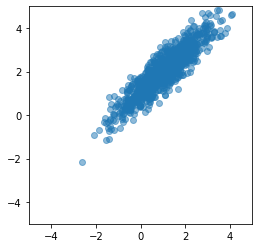

In [2]:
import matplotlib.pyplot as plt

data = sampling_gaus(2, 1000, [1,2], [[1, 0.9], [0.9,1]])

plt.figure(figsize=(4,4))
plt.scatter(data[:,0], data[:,1], alpha=.5);
plt.xlim(-5, 5)
plt.ylim(-5, 5)

mu:  [1.02079689 2.01662665]
sigma:  [[1.0504567  0.94518192]
 [0.94518192 1.04458064]]


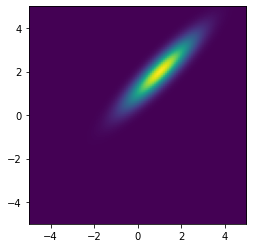

In [8]:
# パラメータの推定
mu_hat = np.mean(data, axis=0)
sigma_hat = np.matmul((data-mu_hat).T, (data-mu_hat))/len(data)

print('mu: ', mu_hat)
print('sigma: ', sigma_hat)

# 推定された分布
x1 = np.linspace(-5, 5, 101)
x2 = np.linspace(-5, 5, 101)
X1, X2 = np.meshgrid(x1, x2)

N = np.array([[N_Gaussian([i, j], mu=mu_hat, sigma=sigma_hat) for i in x1] for j in x2])

plt.figure(figsize=(4,4))
plt.imshow(N, origin='lower', extent=[-5, 5, -5, 5]);

### 2.2 マハラノビス距離とホテリングの$T^2$法
最尤推定量を代入することで、データ$D$を表現する確率密度関数が、
$$
p(\boldsymbol{x}|D)=N(\boldsymbol{x}|\hat{\boldsymbol{\mu}},\hat{\Sigma})
$$

のように得られたとする。  
定義($a(\boldsymbol{x'})=-\ln{p(\boldsymbol{x'}|D)}$)より、  
観測値に関係のない定数を無視すると異常度は、
$$
a(\boldsymbol{x'})=(\boldsymbol{x'}-\hat{\boldsymbol{\mu}})^T\hat{\Sigma}^{-1}(\boldsymbol{x'}-\hat{\boldsymbol{\mu}})
$$

となる。  
これは、観測データ$\boldsymbol{x'}$が、どれだけ標本平均$\hat{\boldsymbol{\mu}}$から離れているかを表すもので、**マハラノビス距離**(の2乗)と呼ばれる。  
$\boldsymbol{x'}$を異常か正常かを判定する閾値をどう決めるかについては、  
ホテリングの$T^2$法では、異常度$a$が従う確率分布を多変量正規分布の仮定に基づいて明示的に求めることができる。  
ホテリングの$T^2$法について次の定理が成り立つ。
>$M$次元正規分布$N(\boldsymbol{\mu},\Sigma)$からの$N$個の独立標本$\{\boldsymbol{x}^{(1)},\cdots,\boldsymbol{x}^{(N)} \}$に基づき、標本平均\hat{\boldsymbol{\mu}}を
$$
\hat{\boldsymbol{\mu}}=\frac{1}{N}\sum_{i=1}^N\boldsymbol{x}^{(n)}
$$
で、標本分散$\hat{\Sigma}$を
$$
\hat{\Sigma}=\frac{1}{N}(\boldsymbol{x}^{(n)}-\hat{\boldsymbol{\mu}})(\boldsymbol{x}^{(n)}-\hat{\boldsymbol{\mu}})^T
$$
で定義する。
$N(\boldsymbol{\mu},\Sigma)$からの独立標本$\boldsymbol{x}'$を新たに観測したとき、以下が成立する。
>1. $\boldsymbol{x}'-\hat{\boldsymbol{\mu}}$は、平均$\boldsymbol{0}$、共分散$\frac{N}{N+1}\Sigma$の$M$次元正規分布に従う
2. $\hat{\Sigma}$は、$\boldsymbol{x}'-\hat{\boldsymbol{\mu}}$と統計的に独立である
3. $T^2=\frac{N-M}{(N+1)M}a(\boldsymbol{x}')$により定義される統計量$T^2$は、自由度$(M,N-M)$のF分布に従う  
ただし、
$$
a(\boldsymbol{x}')=(\boldsymbol{x'}-\hat{\boldsymbol{\mu}})^T\hat{\Sigma}^{-1}(\boldsymbol{x'}-\hat{\boldsymbol{\mu}})
$$
4. $N>>M$のときは、$a(\boldsymbol{x}')$は近似的に、自由度$M'$、スケール因子1のカイ2乗分布に従う

統計量$T^2$を**ホテリング統計量**または**ホテリングの$T^2$**と呼ぶ。  
ほとんどの場合で$N>>M$が成り立つので、異常度はカイ2乗分布に従うものと考える。

カイ2乗分布に基づく異常判定モデルの構築アルゴリズムは以下のようになる。
>所与の誤報率$\alpha$に基づき、カイ2乗分布から方程式
$$
1-\alpha=\int_0^{a_{th}}dx\chi^2(x|M,1)
$$
により閾値$a_{th}$を求めておく
>1. 正常標本が圧倒的だと信じられるデータから標本平均および標本共分散行列
$$
\hat{\boldsymbol{\mu}}=\frac{1}{N}\sum_{i=1}^N\boldsymbol{x}^{(n)}\\
\hat{\Sigma}=\frac{1}{N}(\boldsymbol{x}^{(n)}-\hat{\boldsymbol{\mu}})(\boldsymbol{x}^{(n)}-\hat{\boldsymbol{\mu}})^T
$$
を計算しておく
2. 新たな観測値$\boldsymbol{x}'$を得るたび、異常度としてのマハラノビス距離
$$
a(\boldsymbol{x}')=(\boldsymbol{x'}-\hat{\boldsymbol{\mu}})^T\hat{\Sigma}^{-1}(\boldsymbol{x'}-\hat{\boldsymbol{\mu}})
$$
を計算する
3. $a(\boldsymbol{x}')>a_{th}$なら警報を出す

In [6]:
import scipy.stats as sps

def calc_mahalanobis(x, mu_hat, sigma_hat):
    w = np.matmul(np.linalg.inv(sigma_hat), (x-mu_hat))
    a = np.matmul((x-mu_hat).T, w)
    return a

# 設定
M = 2 #次元
alpha = 0.01 # 誤報率

# 閾値の決定
ath = sps.chi2.ppf(q = 1 - alpha, df = M, scale=1)
print('ath: ', ath)

# 1. 標本平均及び標本標準共分散行列の計算
mu_hat = np.mean(data, axis=0)
sigma_hat = np.matmul((data-mu_hat).T, (data-mu_hat))/len(data)

# 2. 新たな観測値に対するマハラノビス距離の計算
x_new1 = np.array([2, -2])
x_new2 = np.array([0, 1])

a1 = calc_mahalanobis(x_new1, mu_hat, sigma_hat)
a2 = calc_mahalanobis(x_new2, mu_hat, sigma_hat)

# 3. 判定
print("x: ", x_new1, " a: ", a1, ' judge: ', a1>ath)
print("x: ", x_new2, " a: ", a2, ' judge: ', a2>ath)

ath:  9.21034037197618
x:  [ 2 -2]  a:  124.48091554482315  judge:  True
x:  [0 1]  a:  1.0415817560615477  judge:  False


(-5.0, 5.0)

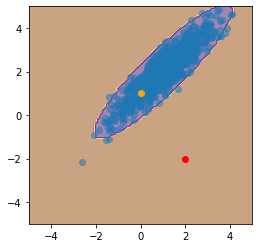

In [7]:
# 結果の可視化
# 正常領域と異常領域を表示
a_grid = np.array([[calc_mahalanobis([i, j], mu_hat, sigma_hat) for i in x1] for j in x2])
a_grid = (a_grid < a_th).astype(int)

plt.figure(figsize=(4,4))
plt.contourf(X1, X2, a_grid, 10, alpha=0.5, cmap='PuOr')
plt.scatter(data[:,0], data[:,1], alpha=.5);
plt.scatter(2, -2, color="red")
plt.scatter(0, 1, color="orange")
plt.xlim(-5, 5)
plt.ylim(-5, 5)

### 2.3 正規分布とカイ2乗分布の関係
1次元正規変数の平方和の分布に関して次の定理が成り立つ。
>$N(0,\sigma^2)$に独立に従う$M$個の確率変数$x_1,\cdots,x_M$と、定数$c>0$により定義される確率変数
$$
u=c(x_1^2+x_2^2+\cdots+x_M^2)
$$
は、自由度$M$、スケール因子$c\sigma^2$のカイ2乗分布$\chi^2(u|M,c\sigma^2)$に従う

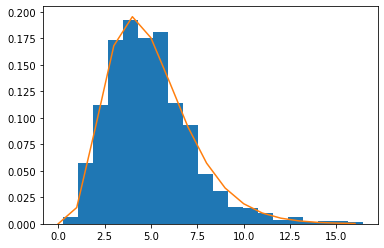

In [137]:
sigma = 0.5
c = 2

# 確率変数の2乗の和
u = [c*np.sum(np.random.normal(0, sigma, 10)**2) for _ in range(1000)]

# カイ2乗分布の確率分布
x = np.arange(0, max(u))
chi = sps.chi2.pdf(x, df = 10, scale=c*0.5**2)

plt.hist(u, bins=20, density=True);
plt.plot(x, chi);

In [132]:
?plt.hist